### Problem 2: Logistic Regression and LDA


You are hired by a tour and travel agency which deals in selling holiday packages. You are provided details of 872 employees of a company. Among these employees, some opted for the package and some didn't. You have to help the company in predicting whether an employee will opt for the package or not on the basis of the information given in the data set. Also, find out the important factors on the basis of which the company will focus on particular employees to sell their packages.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### 2.1 Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it. Perform Univariate and Bivariate Analysis. Do exploratory data analysis.

In [2]:
df = pd.read_csv(r'C:\Me\GreatLakes\05_Predictive Modeling\Week4\Holiday_Package.csv', index_col=0)
df.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
1,no,48412,30,8,1,1,no
2,yes,37207,45,8,0,1,no
3,no,58022,46,9,0,0,no
4,no,66503,31,11,2,0,no
5,no,66734,44,12,0,2,no


In [3]:
df.shape

(872, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872 entries, 1 to 872
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Holliday_Package   872 non-null    object
 1   Salary             872 non-null    int64 
 2   age                872 non-null    int64 
 3   educ               872 non-null    int64 
 4   no_young_children  872 non-null    int64 
 5   no_older_children  872 non-null    int64 
 6   foreign            872 non-null    object
dtypes: int64(5), object(2)
memory usage: 54.5+ KB


In [5]:
df.describe().round(2)

,Salary,age,educ,no_young_children,no_older_children
count,872.00,872.00,872.00,872.00,872.00
mean,47729.17,39.96,9.31,0.31,0.98
std,23418.67,10.55,3.04,0.61,1.09
min,1322.00,20.00,1.00,0.00,0.00
25%,35324.00,32.00,8.00,0.00,0.00
50%,41903.50,39.00,9.00,0.00,1.00
75%,53469.50,48.00,12.00,0.00,2.00
max,236961.00,62.00,21.00,3.00,6.00


In [6]:
df.isnull().sum()

Holliday_Package     0
Salary               0
age                  0
educ                 0
no_young_children    0
no_older_children    0
foreign              0
dtype: int64

In [7]:
dupes = df.duplicated()
print(sum(dupes))

0


In [8]:
df.rename(columns={"Holliday_Package": "Holiday_Package"}, inplace=True)

In [9]:
df['Holiday_Package'].value_counts()

no     471
yes    401
Name: Holiday_Package, dtype: int64

In [10]:
print(round(df['Holiday_Package'].value_counts(normalize=True)*100,2))

no     54.01
yes    45.99
Name: Holiday_Package, dtype: float64


<AxesSubplot:>

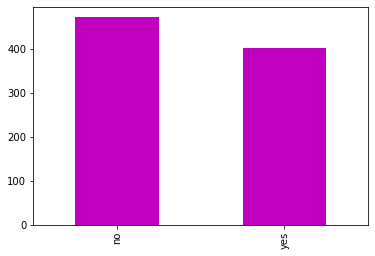

In [11]:
df['Holiday_Package'].value_counts().plot(kind='bar', color='m')

In [12]:
#list of numerical variables
num_vars = [var for var in df.columns if df[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))

#visualize the numerical variables
df[num_vars].head()

Number of numerical variables:  5


,Salary,age,educ,no_young_children,no_older_children
1,48412,30,8,1,1
2,37207,45,8,0,1
3,58022,46,9,0,0
4,66503,31,11,2,0
5,66734,44,12,0,2


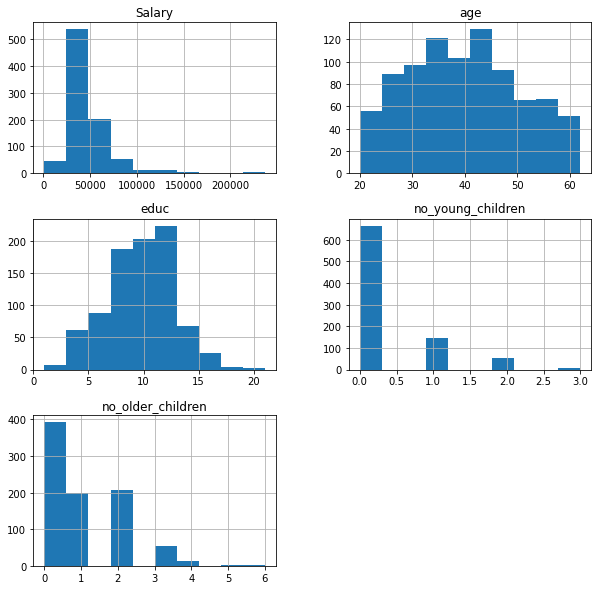

In [13]:
df.hist(figsize=(10,10));

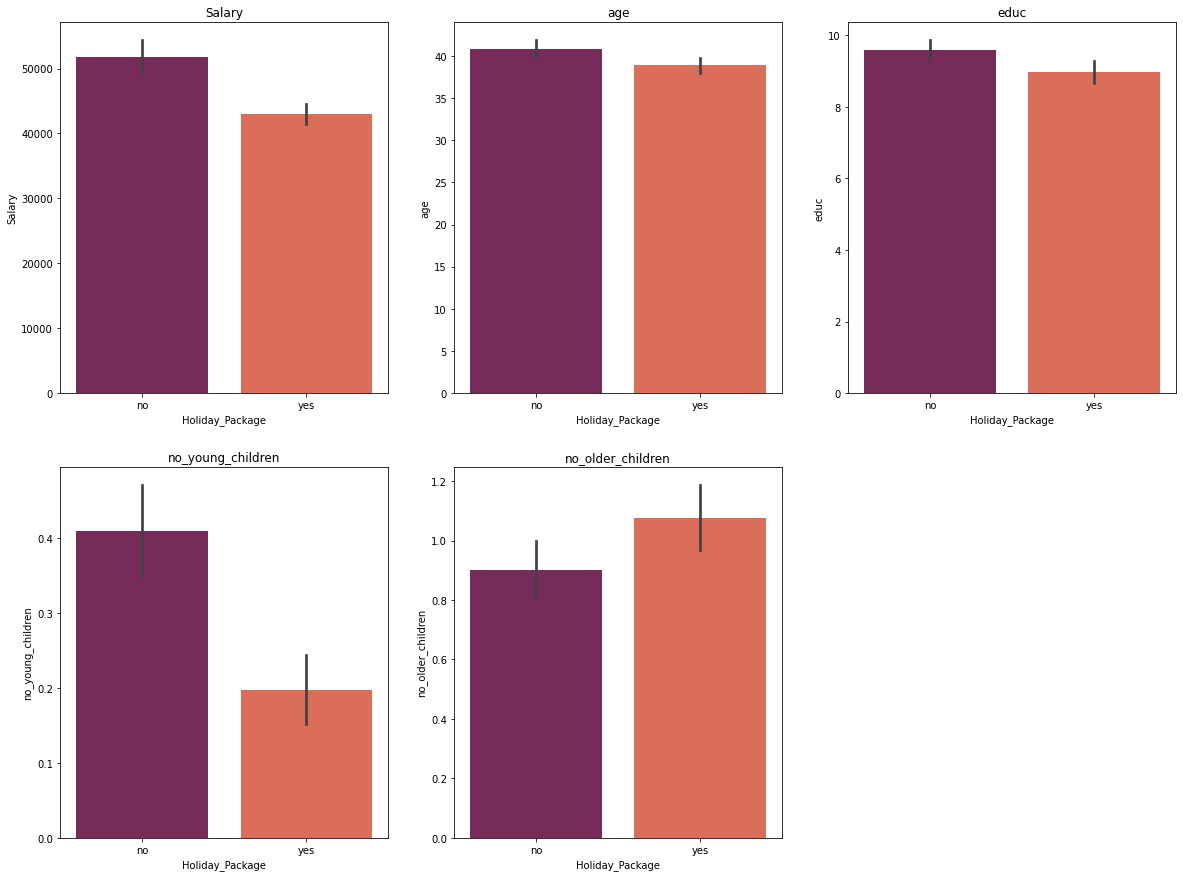

In [14]:
i = 1

plt.figure(figsize=(20,15))
for var in num_vars:
    plt.subplot(2,3,i)
    sns.barplot(data=df, x='Holiday_Package', y=var, palette='rocket')
    plt.title(var)
    i = i+1

<AxesSubplot:xlabel='Holiday_Package', ylabel='Salary'>

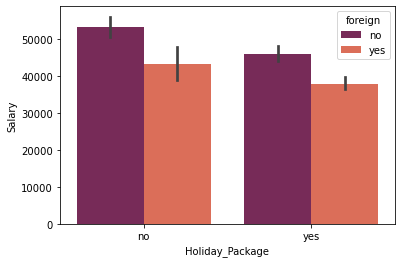

In [15]:
sns.barplot(data=df, x='Holiday_Package', y='Salary', hue='foreign', palette='rocket')

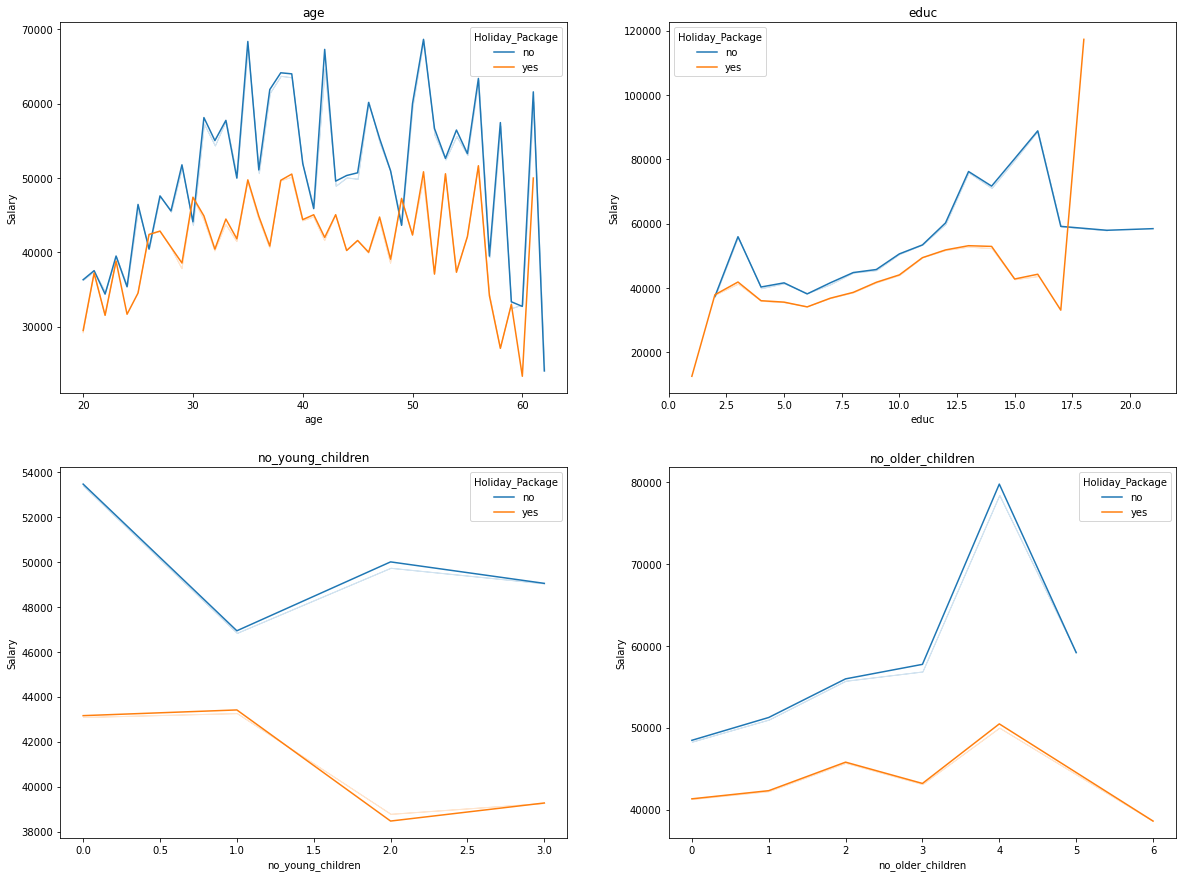

In [16]:
i = 1

plt.figure(figsize=(20,15))
for var in num_vars:
    if var not in 'Salary':
        plt.subplot(2,2,i)
        sns.lineplot(data=df, x=var, y='Salary', hue='Holiday_Package', ci=False)
        plt.title(var)
        i = i+1

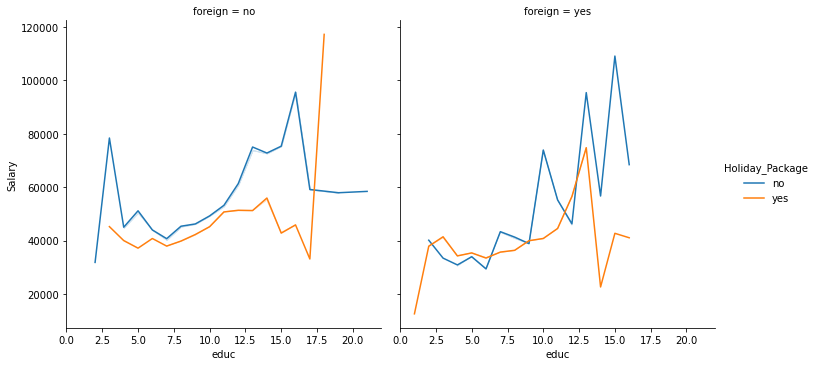

In [17]:
sns.relplot(data=df, x='educ', y='Salary', hue='Holiday_Package', ci=False, col='foreign', kind='line')

In [18]:
df.groupby(by=['Holiday_Package', 'foreign'])[['Salary', 'age']].mean().round(2)

Salary    age
Holiday_Package foreign                 
no              no       53226.79  41.17
                yes      43074.04  39.01
yes             no       46001.65  39.71
                yes      37864.91  37.50

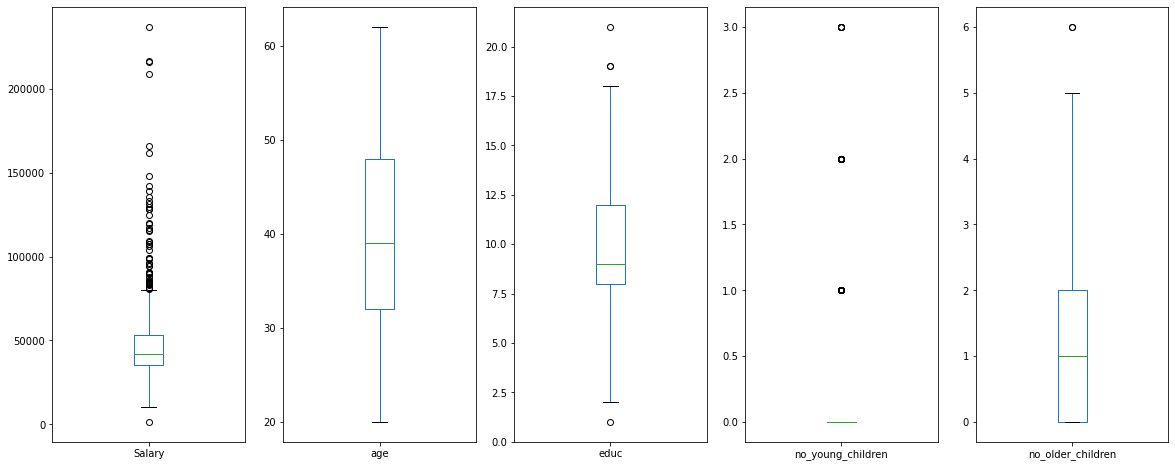

In [19]:
df[num_vars].plot(kind='box', subplots=True, figsize=(20,8));

In [20]:
df_orig = df.copy()
df_outlier = df.copy()

In [21]:
def find_skewed_boundaries(df, variable):

    #Let's calculate the boundary ranges for skewed distributions
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

In [22]:
for var in num_vars:
    if var not in ['no_young_children', 'no_older_children']:
        upper_range, lower_range = find_skewed_boundaries(df_outlier, var)
        df_outlier[var] = np.where(df_outlier[var] > upper_range, upper_range, df_outlier[var])
        df_outlier[var] = np.where(df_outlier[var] < lower_range, lower_range, df_outlier[var])

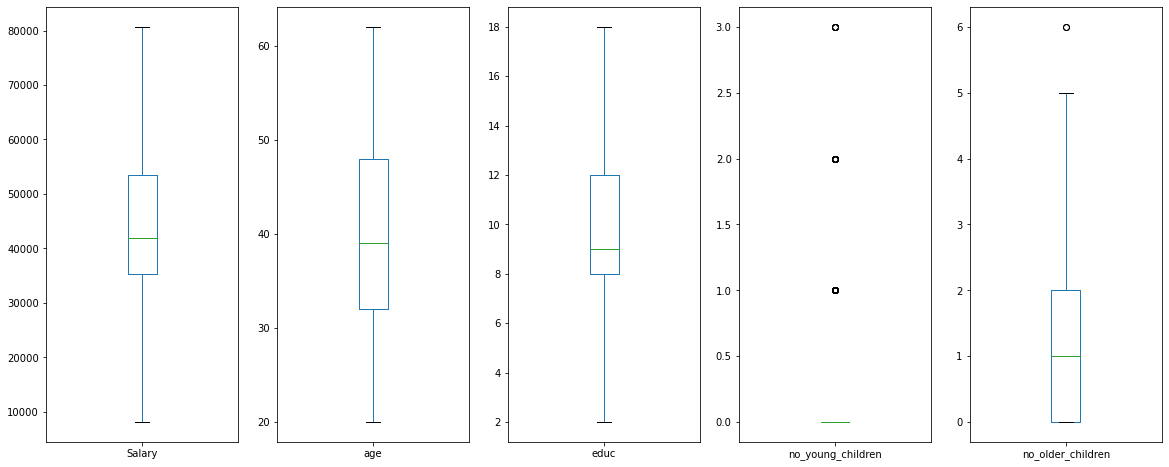

In [23]:
df_outlier[num_vars].plot(kind='box', subplots=True, figsize=(20,8));

Let's create a new variable 'children' in the dataframe - 

In [24]:
df['children'] = df['no_young_children'] + df['no_older_children']
df.head(2)

,Holiday_Package,Salary,age,educ,no_young_children,no_older_children,foreign,children
1,no,48412,30,8,1,1,no,2
2,yes,37207,45,8,0,1,no,1


<AxesSubplot:xlabel='children', ylabel='age'>

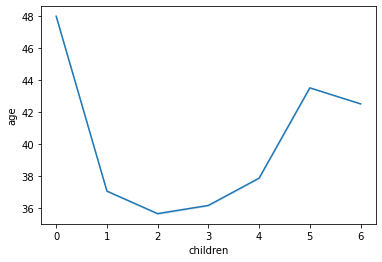

In [25]:
sns.lineplot(data=df, x='children', y='age', ci=False)

In [26]:
df.groupby(by=['children'])[['Salary', 'age']].mean().round(2)

,Salary,age
children,,
0,45926.76,47.97
1,46681.50,37.06
2,47738.89,35.65
3,53312.10,36.16
4,59340.68,37.86
5,59185.50,43.50
6,38605.00,42.50


In [27]:
df.groupby(by=['children', 'Holiday_Package'])[['Salary', 'age']].mean().round(2)

Salary    age
children Holiday_Package                 
0        no               50538.72  52.67
         yes              41141.42  43.09
1        no               49086.47  36.64
         yes              43320.01  37.64
2        no               50838.97  35.20
         yes              44118.18  36.18
3        no               62051.49  36.24
         yes              44124.54  36.08
4        no               65461.00  36.36
         yes              48630.12  40.50
5        no               59185.50  43.50
6        yes              38605.00  42.50

In [28]:
df[df['age'] > 49].groupby('Holiday_Package')['Holiday_Package'].count()

Holiday_Package
no     133
yes     51
Name: Holiday_Package, dtype: int64

In [29]:
df[df['age'] <= 49].groupby('Holiday_Package')['Holiday_Package'].count()

Holiday_Package
no     338
yes    350
Name: Holiday_Package, dtype: int64

In [30]:
df[(df['age'] > 39) & (df['age'] <= 49)].groupby('Holiday_Package')['Holiday_Package'].count()

Holiday_Package
no     116
yes    135
Name: Holiday_Package, dtype: int64

In [31]:
df[(df['age'] > 29) & (df['age'] <= 39)].groupby('Holiday_Package')['Holiday_Package'].count()

Holiday_Package
no     123
yes    150
Name: Holiday_Package, dtype: int64

In [32]:
df[df['age'] < 30].groupby('Holiday_Package')['Holiday_Package'].count()

Holiday_Package
no     99
yes    65
Name: Holiday_Package, dtype: int64

In [33]:
#Age 50 and plus
df_50 = df[(df['age'] > 49) & (df['Holiday_Package'] == 'yes')]
df_50.shape

(51, 8)

In [34]:
#Age between 40 and 49
df_40 = df[(df['age'] > 39) & (df['age'] <= 49) & (df['Holiday_Package'] == 'yes')]
df_40.shape

(135, 8)

In [35]:
#Age between 30 and 39
df_30 = df[(df['age'] > 29) & (df['age'] <= 39) & (df['Holiday_Package'] == 'yes')]
df_30.shape

(150, 8)

In [36]:
#Age less than 30
df_20 = df[(df['age'] < 30) & (df['Holiday_Package'] == 'yes')]
df_20.shape

(65, 8)

In [37]:
df_50.groupby(['Holiday_Package','children','no_young_children'])[['Holiday_Package']].count()

Holiday_Package
Holiday_Package children no_young_children                 
yes             0        0                               43
                1        0                                4
                2        0                                3
                3        0                                1

In [38]:
df_50.groupby(['Holiday_Package','children'])[['Salary']].mean().round(2)

Salary
Holiday_Package children          
yes             0         40249.53
                1         58458.75
                2         33200.00
                3         33178.00

In [39]:
df_40.groupby(['Holiday_Package','children','no_young_children'])[['Holiday_Package']].count()

Holiday_Package
Holiday_Package children no_young_children                 
yes             0        0                               47
                1        0                               38
                2        0                               31
                         1                                2
                3        0                               10
                4        0                                5
                6        0                                2

In [40]:
df_40.groupby(['Holiday_Package','children'])[['Salary']].mean().round(2)

Salary
Holiday_Package children          
yes             0         39955.15
                1         40999.00
                2         46948.24
                3         44739.30
                4         55416.20
                6         38605.00

In [41]:
df_30.groupby(['Holiday_Package','children'])[['Holiday_Package']].count()

Holiday_Package
Holiday_Package children                 
yes             0                      21
                1                      28
                2                      77
                3                      21
                4                       3

In [42]:
df_30.groupby(['Holiday_Package','children','no_young_children'])[['Holiday_Package']].count()

Holiday_Package
Holiday_Package children no_young_children                 
yes             0        0                               21
                1        0                               24
                         1                                4
                2        0                               59
                         1                               13
                         2                                5
                3        0                               16
                         1                                3
                         2                                1
                         3                                1
                4        0                                2
                         1                                1

In [43]:
df_30.groupby(['Holiday_Package','children','no_young_children', 'foreign'])[['Holiday_Package']].count()

Holiday_Package
Holiday_Package children no_young_children foreign                 
yes             0        0                 no                    18
                                           yes                    3
                1        0                 no                    13
                                           yes                   11
                         1                 no                     2
                                           yes                    2
                2        0                 no                    38
                                           yes                   21
                         1                 no                     6
                                           yes                    7
                         2                 no                     4
                                           yes                    1
                3        0                 no                    11
                                           yes                    5
                         1                 no                     1
                                           yes                    2
                         2                 yes                    1
                         3                 yes                    1
                4        0                 no                     1
                                           yes                    1
                         1                 yes                    1

In [44]:
df_30.groupby(['Holiday_Package','children'])[['Salary']].mean().round(2)

Salary
Holiday_Package children          
yes             0         49953.33
                1         44626.21
                2         45223.35
                3         45354.38
                4         37320.00

In [45]:
df_20.groupby(['Holiday_Package','children', 'no_young_children'])[['Holiday_Package']].count()

Holiday_Package
Holiday_Package children no_young_children                 
yes             0        0                               22
                1        0                                5
                         1                               13
                2        0                                6
                         1                                7
                         2                                5
                3        1                                4
                         2                                2
                         3                                1

In [46]:
df_20.groupby(['Holiday_Package','children'])[['Salary']].mean().round(2)

Salary
Holiday_Package children          
yes             0         37007.59
                1         42823.89
                2         36021.78
                3         41120.57

<AxesSubplot:xlabel='Holiday_Package,children'>

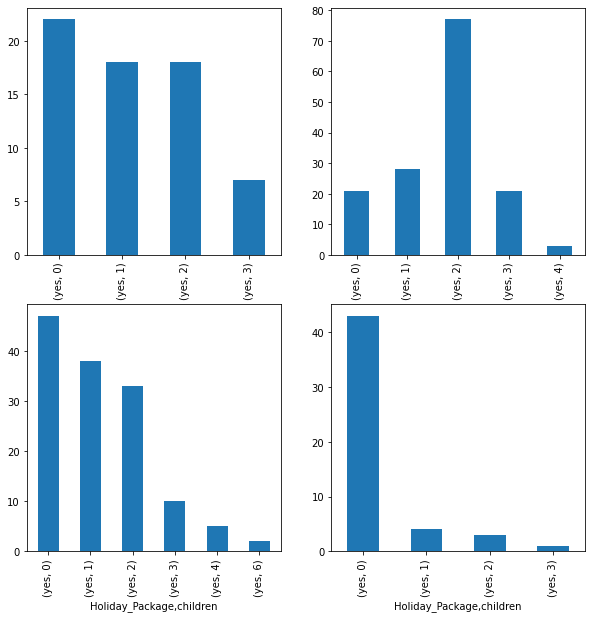

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
df_20.groupby(['Holiday_Package','children'])['Holiday_Package'].count().plot(kind='bar', ax=axs[0,0])
df_30.groupby(['Holiday_Package','children'])['Holiday_Package'].count().plot(kind='bar', ax=axs[0,1])
df_40.groupby(['Holiday_Package','children'])['Holiday_Package'].count().plot(kind='bar', ax=axs[1,0])
df_50.groupby(['Holiday_Package','children'])['Holiday_Package'].count().plot(kind='bar', ax=axs[1,1])

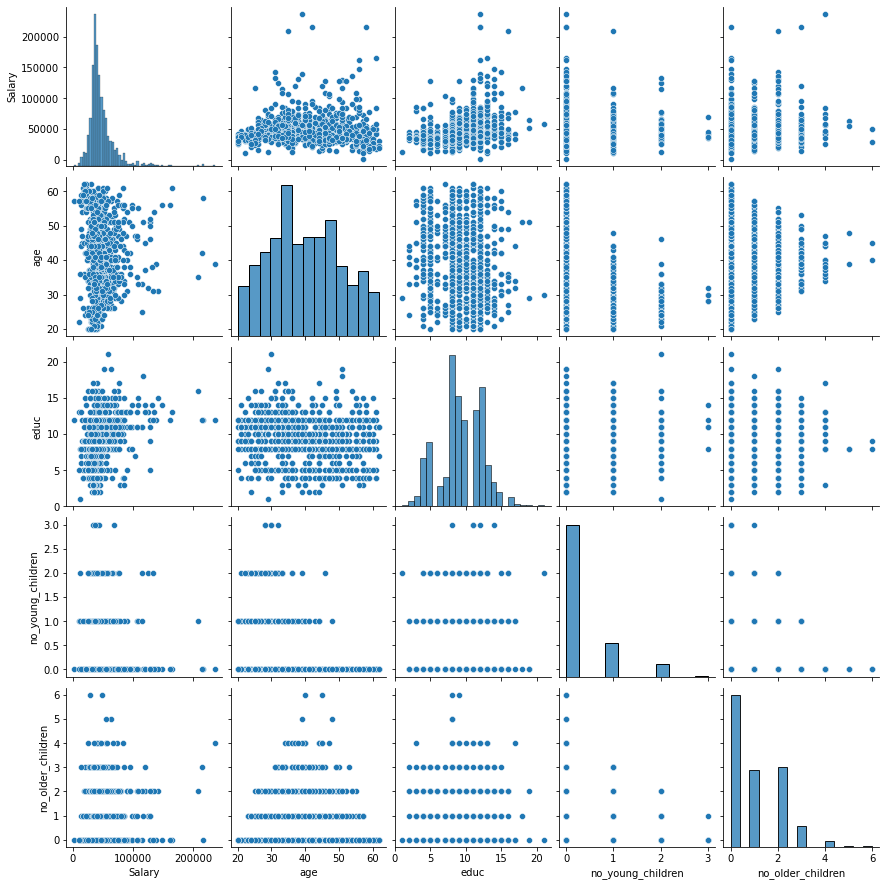

In [48]:
sns.pairplot(df_orig)

<AxesSubplot:>

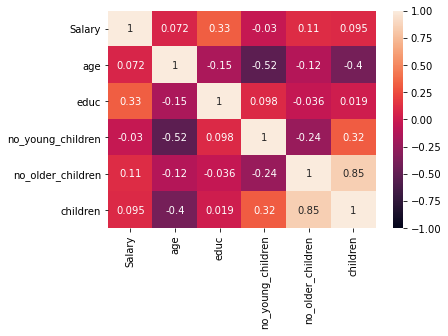

In [49]:
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)

### 2.2 Do not scale the data. Encode the data (having string values) for Modelling. Data Split: Split the data into train and test (70:30). Apply Logistic Regression and LDA (linear discriminant analysis).

In [50]:
df.drop('no_older_children', axis=1, inplace=True)
df.head()

,Holiday_Package,Salary,age,educ,no_young_children,foreign,children
1,no,48412,30,8,1,no,2
2,yes,37207,45,8,0,no,1
3,no,58022,46,9,0,no,0
4,no,66503,31,11,2,no,2
5,no,66734,44,12,0,no,2


In [51]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [52]:
df_encoded.head()

,Salary,age,educ,no_young_children,children,Holiday_Package_yes,foreign_yes
1,48412,30,8,1,2,0,0
2,37207,45,8,0,1,1,0
3,58022,46,9,0,0,0,0
4,66503,31,11,2,2,0,0
5,66734,44,12,0,2,0,0


In [53]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872 entries, 1 to 872
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Salary               872 non-null    int64
 1   age                  872 non-null    int64
 2   educ                 872 non-null    int64
 3   no_young_children    872 non-null    int64
 4   children             872 non-null    int64
 5   Holiday_Package_yes  872 non-null    uint8
 6   foreign_yes          872 non-null    uint8
dtypes: int64(5), uint8(2)
memory usage: 82.6 KB


In [54]:
#Copy all the predictor variables into X dataframe
X = df_encoded.drop('Holiday_Package_yes', axis=1)

#Copy target into the y dataframe. 
y = df_encoded['Holiday_Package_yes']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [56]:
y_train.value_counts(1)

0    0.539344
1    0.460656
Name: Holiday_Package_yes, dtype: float64

In [57]:
y_test.value_counts(1)

0    0.541985
1    0.458015
Name: Holiday_Package_yes, dtype: float64

### LogisticRegression

In [58]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [59]:
ytrain_predict = log_model.predict(X_train)
ytest_predict = log_model.predict(X_test)

In [60]:
ytest_predict_prob=log_model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.563736,0.436264
1,0.570468,0.429532
2,0.694810,0.305190
3,0.559245,0.440755
4,0.625780,0.374220


### LDA

In [61]:
#Build LDA Model and fit the data
clf = LinearDiscriminantAnalysis()
lda_model = clf.fit(X_train, y_train)

In [62]:
ytest_predict_prob=lda_model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.563902,0.436098
1,0.419695,0.580305
2,0.870244,0.129756
3,0.281443,0.718557
4,0.438711,0.561289


In [63]:
# Predict it
ytrain_pred_lda = lda_model.predict(X_train)
ytest_pred_lda = lda_model.predict(X_test)

### 2.3 Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model Final Model: Compare Both the models and write inference which model is best/optimized.

### Check Accuracy, ROC_AUC, Confusion matrix and Classification report for LogisticRegression model

In [101]:
#Accuracy - Train Data
log_model.score(X_train, y_train)

0.5393442622950819

AUC: 0.614


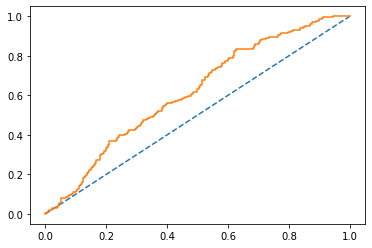

In [102]:
# predict probabilities
probs = log_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

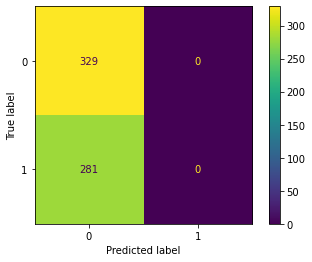

In [103]:
plot_confusion_matrix(log_model,X_train,y_train);

In [67]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70       329
           1       0.00      0.00      0.00       281

    accuracy                           0.54       610
   macro avg       0.27      0.50      0.35       610
weighted avg       0.29      0.54      0.38       610



In [68]:
#Accuracy - Test Data
log_model.score(X_test, y_test)

0.5419847328244275

AUC: 0.578


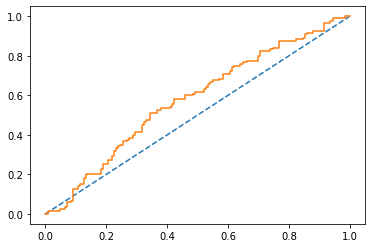

In [69]:
# predict probabilities
probs = log_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

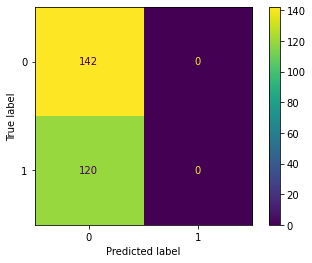

In [70]:
plot_confusion_matrix(log_model,X_test,y_test);

In [71]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70       142
           1       0.00      0.00      0.00       120

    accuracy                           0.54       262
   macro avg       0.27      0.50      0.35       262
weighted avg       0.29      0.54      0.38       262



### Check Accuracy, ROC_AUC, Confusion matrix and Classification report for LDA model

In [72]:
#Accuracy - Train Data
lda_model.score(X_train, y_train)

0.6786885245901639

AUC: 0.748


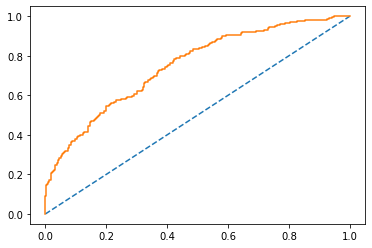

In [73]:
# predict probabilities
probs = lda_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

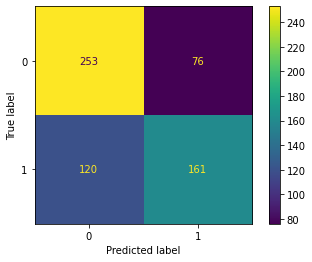

In [74]:
plot_confusion_matrix(lda_model,X_train,y_train);

In [75]:
print(classification_report(y_train, ytrain_pred_lda))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72       329
           1       0.68      0.57      0.62       281

    accuracy                           0.68       610
   macro avg       0.68      0.67      0.67       610
weighted avg       0.68      0.68      0.68       610



In [76]:
#Accuracy - Test Data
lda_model.score(X_test, y_test)

0.6297709923664122

AUC: 0.668


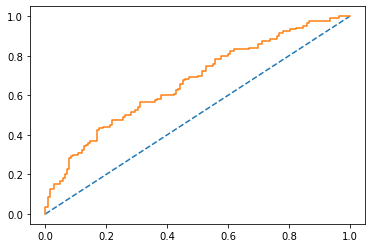

In [77]:
# predict probabilities
probs = lda_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

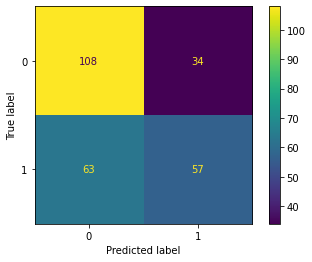

In [78]:
plot_confusion_matrix(lda_model,X_test,y_test);

In [79]:
print(classification_report(y_test, ytest_pred_lda))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69       142
           1       0.63      0.47      0.54       120

    accuracy                           0.63       262
   macro avg       0.63      0.62      0.62       262
weighted avg       0.63      0.63      0.62       262



### Let's also see the effect of outlier treatment on the model performance

In [80]:
df_outlier_enc = pd.get_dummies(df_outlier, drop_first=True)

In [81]:
df_outlier_enc.head(2)

,Salary,age,educ,no_young_children,no_older_children,Holiday_Package_yes,foreign_yes
1,48412.0,30.0,8.0,1,1,0,0
2,37207.0,45.0,8.0,0,1,1,0


In [82]:
df_outlier_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872 entries, 1 to 872
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Salary               872 non-null    float64
 1   age                  872 non-null    float64
 2   educ                 872 non-null    float64
 3   no_young_children    872 non-null    int64  
 4   no_older_children    872 non-null    int64  
 5   Holiday_Package_yes  872 non-null    uint8  
 6   foreign_yes          872 non-null    uint8  
dtypes: float64(3), int64(2), uint8(2)
memory usage: 82.6 KB


In [83]:
#Copy all the predictor variables into X dataframe
X_out = df_outlier_enc.drop('Holiday_Package_yes', axis=1)

#Copy target into the y dataframe. 
y_out = df_outlier_enc['Holiday_Package_yes']

In [84]:
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_out, y_out, test_size=0.3, random_state=0, stratify=y)

In [85]:
log_model.fit(X_train_out, y_train_out)

LogisticRegression()

In [86]:
ytrain_predict = log_model.predict(X_train_out)
ytest_predict = log_model.predict(X_test_out)

In [87]:
#Accuracy - Train Data
log_model.score(X_train_out, y_train_out)

0.5393442622950819

In [88]:
#Accuracy - Test Data
log_model.score(X_test_out, y_test_out)

0.5419847328244275

In [104]:
lda_model.fit(X_train_out, y_train_out)

LinearDiscriminantAnalysis()

In [106]:
ytrain_predict = log_model.predict(X_train_out)
ytest_predict = log_model.predict(X_test_out)

In [107]:
lda_model.score(X_train_out, y_train_out)

0.6770491803278689

In [108]:
lda_model.score(X_test_out, y_test_out)

0.6335877862595419

### Applying GridSearchCV for Logistic Regression

In [89]:
grid={'penalty':['l1', 'l2', 'elasticnet', 'none'],
      'solver':['sag','lbfgs','newton-cg','liblinear'],
      'C':[1, 5, 10],
      'max_iter':[10000,100000],
      'tol':[0.001, 0.0001,0.00001]}

In [90]:
model = LogisticRegression()

In [91]:
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv=10,n_jobs=-1)

In [92]:
X_train.head()

,Salary,age,educ,no_young_children,children,foreign_yes
705,41705,29,5,1,2,1
158,48177,44,10,0,2,0
174,40855,39,11,2,2,0
104,32432,56,7,0,0,0
14,148221,56,14,0,0,0


In [93]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'max_iter': [10000, 100000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['sag', 'lbfgs', 'newton-cg', 'liblinear'],
                         'tol': [0.001, 0.0001, 1e-05]})

In [94]:
print(grid_search.best_params_,'\n')
print(grid_search.best_estimator_)

{'C': 5, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-05} 

LogisticRegression(C=5, max_iter=10000, solver='liblinear', tol=1e-05)


In [95]:
best_model = grid_search.best_estimator_
best_model

LogisticRegression(C=5, max_iter=10000, solver='liblinear', tol=1e-05)

In [96]:
#Prediction on the training set

ytrain_predict = best_model.predict(X_train)
ytest_predict = best_model.predict(X_test)

In [97]:
#Accuracy - Train Data
best_model.score(X_train, y_train)

0.6672131147540984

In [98]:
best_model.score(X_test, y_test)

0.6603053435114504

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       329
           1       0.68      0.52      0.59       281

    accuracy                           0.67       610
   macro avg       0.67      0.66      0.65       610
weighted avg       0.67      0.67      0.66       610
 



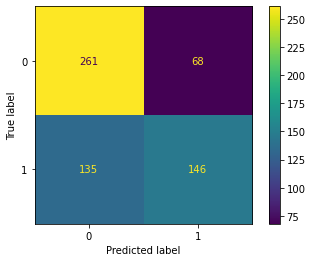

In [99]:
## Confusion matrix on the training data

plot_confusion_matrix(best_model,X_train,y_train)
print(classification_report(y_train, ytrain_predict),'\n');

              precision    recall  f1-score   support

           0       0.65      0.82      0.72       142
           1       0.69      0.47      0.56       120

    accuracy                           0.66       262
   macro avg       0.67      0.65      0.64       262
weighted avg       0.67      0.66      0.65       262
 



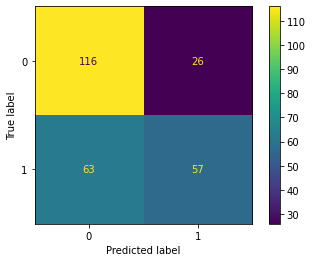

In [100]:
## Confusion matrix on the test data

plot_confusion_matrix(best_model,X_test, y_test)
print(classification_report(y_test, ytest_predict),'\n');